<a href="https://colab.research.google.com/github/amilkh/cs230-fer/blob/75-soa/fer2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
%tensorflow_version 1.4

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.4`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.python.lib.io import file_io

import keras
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau

%matplotlib inline

In [28]:
print(tf.__version__)
print(keras.__version__)

1.15.0
2.2.5


In [0]:
EPOCHS = 100
BS = 128
DROPOUT_RATE = 0.25
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

#data = pd.read_csv('/content/drive/My Drive/cs230 project/collab/fer2013/fer2013.csv')

data = pd.read_csv('/content/drive/My Drive/cs230 project/collab/fer2013/icml_face_data.csv') 

print(data.head())

print(data.columns)

data_train = data[data[' Usage'] == 'Training']

print('Number samples in the training dataset: ', data_train.shape[0])
data_dev = data[data[' Usage'] == 'PublicTest']

print('Number samples in the development dataset: ', data_dev.shape[0]) 
print(data_dev.head())
data_test = data[data[' Usage'] == 'PrivateTest']

print('Number samples in the development dataset: ', data_dev.shape[0]) 
print(data_test.head())
data_train.to_csv('/content/drive/My Drive/cs230 project/collab/fer2013/train.csv') 
data_dev.to_csv('/content/drive/My Drive/cs230 project/collab/fer2013/dev.csv') 
data_test.to_csv('/content/drive/My Drive/cs230 project/collab/fer2013/test.csv')

print(data_train.shape) 
print(data_dev.shape) 
print(data_test.shape)

In [0]:
# Function that reads the data from the csv file, increases the size of the images and returns the images and their labels
    # dataset: Data path
def get_data(dataset):
    
    file_stream = file_io.FileIO(dataset, mode='r')
    data = pd.read_csv(file_stream)

    #data = pd.read_csv('fer2013/fer2013.csv')
    data[' pixels'] = data[' pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])

    # Retrieve train input and target
    X, Y = data[' pixels'].tolist(), data['emotion'].values
    
    # Reshape images to 4D (num_samples, width, height, num_channels)
    X_res = np.array(X, dtype='float32').reshape(-1,48,48,1)
    # Normalize images with max (the maximum pixel intensity is 255)
    X_res = X_res/255.0
    #image_resized = resize(image, (image.shape[0] // 4, image.shape[1] // 4), anti_aliasing=True)

    Y_res = np.zeros((Y.size, 7))
    Y_res[np.arange(Y.size),Y] = 1    
    
    return  X_res, Y_res

In [0]:
training_dataset_dir = '/content/drive/My Drive/cs230 project/collab/fer2013/train.csv'
dev_dataset_dir = '/content/drive/My Drive/cs230 project/collab/fer2013/dev.csv'
# Data preparation
X_train, Y_train  = get_data(training_dataset_dir)
X_dev, Y_dev      = get_data(dev_dataset_dir)

# Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches) indefinitely
# rescale:          Rescaling factor (defaults to None). Multiply the data by the value provided (before applying any other transformation)
# rotation_range:   Int. Degree range for random rotations
# shear_range:      Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
# zoom_range:       Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range]
# fill_mode :       Points outside the boundaries of the input are filled according to the given mode: {"constant", "nearest", "reflect" or "wrap"}
# horizontal_flip:  Boolean. Randomly flip inputs horizontally
train_datagen = ImageDataGenerator(
    rotation_range  = 10,
    shear_range     = 5, # 10 degrees
    zoom_range      = 0.1,
    fill_mode       = 'reflect',
    horizontal_flip = True)

# Takes numpy data & label arrays, and generates batches of augmented/normalized data. Yields batcfillhes indefinitely, in an infinite loop
    # x:            Data. Should have rank 4. In case of grayscale data, the channels axis should have value 1, and in case of RGB data, 
    #               it should have value 3
    # y:            Labels
    # batch_size:   Int (default: 32)
train_generator = train_datagen.flow(X_train, Y_train,  batch_size  = BS)

# Implement below paper CPCPCPFF depth 5, 2.4m params
# http://openaccess.thecvf.com/content_cvpr_2016_workshops/w28/papers/Kim_Fusing_Aligned_and_CVPR_2016_paper.pdf
# Reference: https://arxiv.org/pdf/1612.02903.pdf
model = Sequential()
model.add(Conv2D(64, (5, 5), activation='relu',padding='same', input_shape=(48,48,1),name="conv1"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool1"))
model.add(Dropout(DROPOUT_RATE))
model.add(Conv2D(96, (5, 5), activation='relu',padding='same',name="conv2"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool2"))         
model.add(Dropout(DROPOUT_RATE))
model.add(Conv2D(256, (5, 5), activation='relu',padding='same',name="conv3"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool3"))
model.add(Conv2D(256, (5, 5), activation='relu',padding='same',name="conv4"))

model.add(Flatten())
model.add(Dense(2048, activation='relu',name='fc1'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax',name='fcsoftmax'))

#TODO: weight decay of 0.0001...initial learning rate is set to 0.01 and reduced by a factor of 2 at every 25 epoch
sgd = SGD(lr=SGD_LEARNING_RATE,momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])

In [0]:
# Implement below paper CPCPCPFF depth 5, 2.4m params
# http://openaccess.thecvf.com/content_cvpr_2016_workshops/w28/papers/Kim_Fusing_Aligned_and_CVPR_2016_paper.pdf
# Reference: https://arxiv.org/pdf/1612.02903.pdf
modelSOA = Sequential()
modelSOA.add(Conv2D(32, (5, 5), activation='relu',padding='same', input_shape=(48,48,1),name="conv1"))
modelSOA.add(BatchNormalization())
modelSOA.add(MaxPooling2D(pool_size=(2, 2),name="maxpool1"))
modelSOA.add(Dropout(DROPOUT_RATE))
modelSOA.add(Conv2D(32, (4, 4), activation='relu',padding='same',name="conv2"))
modelSOA.add(BatchNormalization())
modelSOA.add(MaxPooling2D(pool_size=(2, 2),name="maxpool2"))         
modelSOA.add(Dropout(DROPOUT_RATE))
modelSOA.add(Conv2D(64, (5, 5), activation='relu',padding='same',name="conv3"))
modelSOA.add(BatchNormalization())
modelSOA.add(MaxPooling2D(pool_size=(2, 2),name="maxpool3"))
modelSOA.add(Flatten())
modelSOA.add(Dense(1024, activation='relu',name='fc1'))
modelSOA.add(Dropout(0.5))
modelSOA.add(Dense(7, activation='softmax',name='fcsoftmax'))

#TODO: weight decay of 0.0001...initial learning rate is set to 0.01 and reduced by a factor of 2 at every 25 epoch
sgd = SGD(lr=SGD_LEARNING_RATE,momentum=0.9, decay=SGD_DECAY, nesterov=True)
modelSOA.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
#rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100)
rlrop = ReduceLROnPlateau(monitor='val_acc',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)
model = modelSOA

In [33]:
history = modelSOA.fit_generator(
    generator = train_generator,
    validation_data=(X_dev, Y_dev), 
    steps_per_epoch=len(X_train) // BS,
    shuffle=True,
    epochs=EPOCHS,
    callbacks=[rlrop]) 

Epoch 1/100
224/224 [==============================] - 11s 49ms/step - loss: 2.0007 - acc: 0.2769 - val_loss: 1.6824 - val_acc: 0.3369
Epoch 2/100
224/224 [==============================] - 10s 45ms/step - loss: 1.6938 - acc: 0.3245 - val_loss: 1.6143 - val_acc: 0.3605
Epoch 3/100
224/224 [==============================] - 10s 45ms/step - loss: 1.6441 - acc: 0.3526 - val_loss: 1.5652 - val_acc: 0.3990
Epoch 4/100
224/224 [==============================] - 10s 45ms/step - loss: 1.6028 - acc: 0.3752 - val_loss: 1.5135 - val_acc: 0.4129
Epoch 5/100
224/224 [==============================] - 10s 44ms/step - loss: 1.5761 - acc: 0.3850 - val_loss: 1.4922 - val_acc: 0.4238
Epoch 6/100
224/224 [==============================] - 10s 45ms/step - loss: 1.5385 - acc: 0.3989 - val_loss: 1.4503 - val_acc: 0.4433
Epoch 7/100
224/224 [==============================] - 10s 45ms/step - loss: 1.5129 - acc: 0.4132 - val_loss: 1.4352 - val_acc: 0.4372
Epoch 8/100
224/224 [==============================] - 

In [38]:
print('\n# Evaluate on dev data')
results_dev = model.evaluate(X_dev, Y_dev , batch_size=128)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data
3589/3589 [==============================] - 0s 73us/step
dev loss, dev acc: [1.1673159183782267, 0.6085260518291727]


In [39]:
test_dataset_dir = '/content/drive/My Drive/cs230 project/collab/fer2013/test.csv'
X_test, Y_test      = get_data(test_dataset_dir)

print('\n# Evaluate on test data')
results_test = model.evaluate(X_test, Y_test , batch_size=128)
print('test loss, test acc:', results_test)


# Evaluate on test data
3589/3589 [==============================] - 0s 74us/step
test loss, test acc: [1.1082359130218455, 0.6085260518291727]


In [0]:
lr_str = '-SGD_LR_%.5f' % SGD_LEARNING_RATE
epoch_str = '-EPOCHS_' + str(EPOCHS)
bs_str = '-BS_' + str(BS)
dropout_str = '-DROPOUT_' + str(DROPOUT_RATE)
model.save('/content/drive/My Drive/cs230 project/collab/fer2013/models/soa' + lr_str + epoch_str + bs_str + dropout_str + '.h5')

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


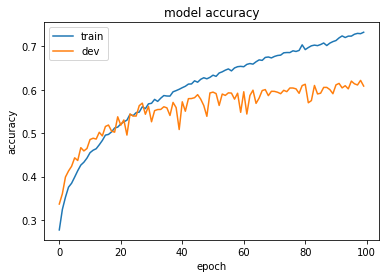

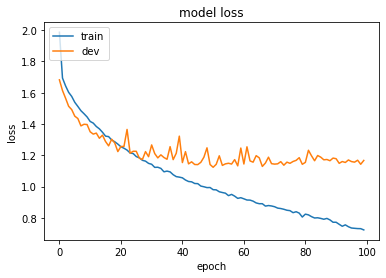

In [37]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()